In [1]:

! pip install python-Levenshtein
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import lru_cache
from Levenshtein import distance as levenshtein_distance
from collections import defaultdict
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Прочтение таблиц

In [3]:
df = pd.read_excel("/content/drive/MyDrive/BioCode/Wing_And_A_Prayer.xlsx")
df.head()

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene
0,0,35307,0.024635,TGTGCCAGCACCCCCGATAGCGGGGGCACAGATACGCAGTATTTT,CASTPDSGGTDTQYF,TRBV7-2,TRBJ2-3
1,1,26316,0.018362,TGTGCCAGCAGTGACAAAAATTCACCCCTCCACTTT,CASSDKNSPLHF,TRBV2,TRBJ1-6
2,2,23161,0.016160,TGCGCCAGCAGCCTGACAGACAATGAGCAGTTCTTC,CASSLTDNEQFF,TRBV4-3,TRBJ2-1
3,3,20802,0.014514,TGTGCCAGCAGCCCGGGACTAAATGCCGCCTACGAGCAGTACGTC,CASSPGLNAAYEQYV,TRBV7-2,TRBJ2-7
4,4,11315,0.007895,TGTGCCAGCAGCTTACAGGGGGCTACGCAGTATTTT,CASSLQGATQYF,TRBV11-3,TRBJ2-3


In [4]:
database = pd.read_excel("/content/drive/MyDrive/BioCode/vdjdb.slim.xlsx")

In [5]:
database_exp = database.rename(columns={'cdr3': 'CDR3.amino.acid.sequence'})

In [6]:
df = df.sort_values(by='Read.count', ascending=False)
df

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene
0,0,35307,2.463501e-02,TGTGCCAGCACCCCCGATAGCGGGGGCACAGATACGCAGTATTTT,CASTPDSGGTDTQYF,TRBV7-2,TRBJ2-3
1,1,26316,1.836166e-02,TGTGCCAGCAGTGACAAAAATTCACCCCTCCACTTT,CASSDKNSPLHF,TRBV2,TRBJ1-6
2,2,23161,1.616030e-02,TGCGCCAGCAGCCTGACAGACAATGAGCAGTTCTTC,CASSLTDNEQFF,TRBV4-3,TRBJ2-1
3,3,20802,1.451433e-02,TGTGCCAGCAGCCCGGGACTAAATGCCGCCTACGAGCAGTACGTC,CASSPGLNAAYEQYV,TRBV7-2,TRBJ2-7
4,4,11315,7.894898e-03,TGTGCCAGCAGCTTACAGGGGGCTACGCAGTATTTT,CASSLQGATQYF,TRBV11-3,TRBJ2-3
...,...,...,...,...,...,...,...
376312,606150,1,6.977374e-07,TGTGCCAGCACCCAAGGTACAACCTACGAGCAGTACTTC,CASTQGTTYEQYF,TRBV7-9,TRBJ2-7
376311,682332,1,6.977374e-07,TGTGCCAGCACCCAAGGGTTGCATGAGCAGTTCTTC,CASTQGLHEQFF,TRBV7-2,TRBJ2-1
376310,273592,1,6.977374e-07,TGTGCCAGCACCCAAGGGTTAGGGGCCCCCTACAATGAGCAGTTCTTC,CASTQGLGAPYNEQFF,TRBV27,TRBJ2-1
376309,682333,1,6.977374e-07,TGTGCCAGCACCCAAGGGGTCTATGGCTACACCTTC,CASTQGVYGYTF,TRBV6-5,TRBJ1-2


In [41]:
data_claster = df[:3000]
data_claster

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene
0,0,35307,0.024635,TGTGCCAGCACCCCCGATAGCGGGGGCACAGATACGCAGTATTTT,CASTPDSGGTDTQYF,TRBV7-2,TRBJ2-3
1,1,26316,0.018362,TGTGCCAGCAGTGACAAAAATTCACCCCTCCACTTT,CASSDKNSPLHF,TRBV2,TRBJ1-6
2,2,23161,0.016160,TGCGCCAGCAGCCTGACAGACAATGAGCAGTTCTTC,CASSLTDNEQFF,TRBV4-3,TRBJ2-1
3,3,20802,0.014514,TGTGCCAGCAGCCCGGGACTAAATGCCGCCTACGAGCAGTACGTC,CASSPGLNAAYEQYV,TRBV7-2,TRBJ2-7
4,4,11315,0.007895,TGTGCCAGCAGCTTACAGGGGGCTACGCAGTATTTT,CASSLQGATQYF,TRBV11-3,TRBJ2-3
...,...,...,...,...,...,...,...
2912,3010,18,0.000013,TGCGCCAGCAGCCCCCGAACGGCTAATGAAAAACTGTTTTTT,CASSPRTANEKLFF,TRBV5-1,TRBJ1-4
2913,2964,18,0.000013,TGCGCCAGCAGCCCCGAACAGGGAATCGATTCACCCCTCCACTTT,CASSPEQGIDSPLHF,TRBV5-1,TRBJ1-6
2914,2883,18,0.000013,TGCGCCAGCAGCCGTCAAGAACAGGGCTCCTATAATTCACCCCTCC...,CASSRQEQGSYNSPLHF,TRBV5-1,TRBJ1-6
2915,2963,18,0.000013,TGCGCCAGCAGCCTAACGAAACAGGGCTTCGGGGAGCTGTTTTTT,CASSLTKQGFGELFF,TRBV4-3,TRBJ2-2


# Функция кластеризации

In [42]:
# Кэшированная функция для вычисления расстояния Левенштейна
@lru_cache(maxsize=None)
def cached_levenshtein_distance(seq1, seq2):
    return levenshtein_distance(seq1, seq2)

# Функция для кластеризации последовательностей
def cluster_sequences(sequences, max_distance=1):
    clusters = []
    for seq in sequences:
        added_to_cluster = False
        for cluster in clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for existing_seq in cluster):
                cluster.append(seq)
                added_to_cluster = True
                break
        if not added_to_cluster:
            clusters.append([seq])
    return clusters

# Функция для объединения кластеров
def merge_clusters(clusters, max_distance=1):
    merged_clusters = []
    for cluster in clusters:
        added_to_cluster = False
        for merged_cluster in merged_clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for seq in cluster for existing_seq in merged_cluster):
                merged_cluster.extend(cluster)
                added_to_cluster = True
                break
        if not added_to_cluster:
            merged_clusters.append(cluster)
    return merged_clusters

# Пример последовательностей аминокислот
sequences = data_claster['CDR3.amino.acid.sequence']

# Разделение данных на части
chunk_size = len(sequences) // 100
chunks = [sequences[i:i + chunk_size] for i in range(0, len(sequences), chunk_size)]

# Кластеризация каждой части
all_clusters = []
for chunk in chunks:
    all_clusters.extend(cluster_sequences(chunk, max_distance=1))

# Объединение кластеров
final_clusters = merge_clusters(all_clusters, max_distance=1)

# Вывод результатов
# Создание DataFrame
cluster_data = []
for i, cluster in enumerate(final_clusters):
    for seq in cluster:
        cluster_data.append({'Cluster': i + 1, 'Sequence': seq})

results_df = pd.DataFrame(cluster_data)

In [43]:
# Создание нового DataFrame с данными из data_claster и номером кластера
cluster_assignments = {}
for i, cluster in enumerate(final_clusters):
  for seq in cluster:
    cluster_assignments[seq] = i + 1

results_df = data_claster.copy()
results_df['Cluster'] = results_df['CDR3.amino.acid.sequence'].map(cluster_assignments)

# Вывод нового DataFrame results_df
results_df


,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene,Cluster
0,0,35307,0.024635,TGTGCCAGCACCCCCGATAGCGGGGGCACAGATACGCAGTATTTT,CASTPDSGGTDTQYF,TRBV7-2,TRBJ2-3,1
1,1,26316,0.018362,TGTGCCAGCAGTGACAAAAATTCACCCCTCCACTTT,CASSDKNSPLHF,TRBV2,TRBJ1-6,2
2,2,23161,0.016160,TGCGCCAGCAGCCTGACAGACAATGAGCAGTTCTTC,CASSLTDNEQFF,TRBV4-3,TRBJ2-1,3
3,3,20802,0.014514,TGTGCCAGCAGCCCGGGACTAAATGCCGCCTACGAGCAGTACGTC,CASSPGLNAAYEQYV,TRBV7-2,TRBJ2-7,4
4,4,11315,0.007895,TGTGCCAGCAGCTTACAGGGGGCTACGCAGTATTTT,CASSLQGATQYF,TRBV11-3,TRBJ2-3,5
...,...,...,...,...,...,...,...,...
2912,3010,18,0.000013,TGCGCCAGCAGCCCCCGAACGGCTAATGAAAAACTGTTTTTT,CASSPRTANEKLFF,TRBV5-1,TRBJ1-4,2835
2913,2964,18,0.000013,TGCGCCAGCAGCCCCGAACAGGGAATCGATTCACCCCTCCACTTT,CASSPEQGIDSPLHF,TRBV5-1,TRBJ1-6,2836
2914,2883,18,0.000013,TGCGCCAGCAGCCGTCAAGAACAGGGCTCCTATAATTCACCCCTCC...,CASSRQEQGSYNSPLHF,TRBV5-1,TRBJ1-6,2166
2915,2963,18,0.000013,TGCGCCAGCAGCCTAACGAAACAGGGCTTCGGGGAGCTGTTTTTT,CASSLTKQGFGELFF,TRBV4-3,TRBJ2-2,2837


# Подсчёт Total Read Proportion

In [44]:

# Подсчет количества последовательностей в каждом кластере
cluster_counts = {i + 1: len(cluster) for i, cluster in enumerate(final_clusters)}
# Подсчет суммарного Read.proportion для каждого кластера
cluster_proportions = {}
for index, row in data_claster.iterrows():
  seq = row['CDR3.amino.acid.sequence']
  proportion = row['Read.proportion']
  for i, cluster in enumerate(final_clusters):
    if seq in cluster:
      cluster_proportions[i + 1] = cluster_proportions.get(i + 1, 0) + proportion
      break

# Создание DataFrame с суммарными пропорциями, номерами кластеров и количеством последовательностей
proportions_data = []
for cluster_number, total_proportion in cluster_proportions.items():
  proportions_data.append({'Cluster': cluster_number,
               'Total Read Proportion': total_proportion,
               'Sequence Count': cluster_counts[cluster_number]})



# Сортировка по Sequence Count

In [45]:
proportions_df = pd.DataFrame(proportions_data)
proportions_df = proportions_df.sort_values(by='Sequence Count', ascending=False)
proportions_df

,Cluster,Total Read Proportion,Sequence Count
421,422,0.000257,13
45,46,0.000731,10
654,655,0.000244,10
403,404,0.000134,6
22,23,0.001229,5
...,...,...,...
988,989,0.000030,1
989,990,0.000030,1
990,991,0.000030,1
991,992,0.000030,1


# Сортировка по Total Read Proportion

In [46]:
proportions_df_sorted = proportions_df.sort_values(by='Total Read Proportion', ascending=False)
#proportions_df_sorted = proportions_df_sorted.loc[proportions_df_sorted['Sequence Count'] > 1]
proportions_df_sorted

,Cluster,Total Read Proportion,Sequence Count
0,1,0.024635,1
1,2,0.018362,1
2,3,0.016175,2
3,4,0.014514,1
4,5,0.007914,2
...,...,...,...
2832,2833,0.000013,1
2833,2834,0.000013,1
2834,2835,0.000013,1
2835,2836,0.000013,1


# Выбор кластера

In [47]:
full = pd.merge(results_df, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [48]:
full = full[['gene', 'Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,TRB,22,CASSLTGNTEAFF,0.001165,TRBV6-5,TRBJ1-1,TRBV12-4*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
1,TRB,22,CASSLTGNTEAFF,0.001165,TRBV6-5,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
2,TRB,22,CASSLTGNTEAFF,0.001165,TRBV6-5,TRBJ1-1,TRBV7-3*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Pol
3,TRB,26,CASSQVGGNTEAFF,0.000984,TRBV3-1,TRBJ1-1,TRBV4-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
4,TRB,46,CASSLGPNTEAFF,0.000376,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
...,...,...,...,...,...,...,...,...,...,...,...,...
153,TRB,2774,CASRPTATNEKLFF,0.000013,TRBV2,TRBJ1-4,TRBV2*01,TRBJ1-4*01,MHCII,HomoSapiens,HIV-1,Gag
154,TRB,404,CASSFGDTQYF,0.000013,TRBV12-4,TRBJ2-3,TRBV14*01,TRBJ2-5*01,MHCI,MusMusculus,InfluenzaA,PA
155,TRB,404,CASSFTDTQYF,0.000013,TRBV25-1,TRBJ2-3,TRBV28*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,pp65
156,TRB,404,CASSFTDTQYF,0.000013,TRBV25-1,TRBJ2-3,TRBV12-4*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,IE1


In [49]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7]) & (full['gene'] == 'TRB')]
full_vj

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
4,TRB,46,CASSLGPNTEAFF,0.000376,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
5,TRB,46,CASSLGPNTEAFF,0.000376,TRBV12-4,TRBJ1-1,TRBV12-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
10,TRB,134,CASSSAYYGYTF,0.000142,TRBV12-4,TRBJ1-2,"TRBV12-4*01,TRBV12-3*01",TRBJ1-2*01,MHCI,HomoSapiens,CMV,pp65
11,TRB,151,CASSSVNEAFF,0.000132,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV19*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
12,TRB,209,CASSFGQAWETQYF,0.000103,TRBV7-9,TRBJ2-5,TRBV7-9*01,TRBJ2-5*01,MHCI,HomoSapiens,CMV,pp65
13,TRB,216,CSVGNEQFF,0.000099,TRBV29-1,TRBJ2-1,TRBV29-1*01,TRBJ2-1*01,MHCI,HomoSapiens,SARS-CoV-2,Nucleocapsid
14,TRB,216,CSVGNEQFF,0.000099,TRBV29-1,TRBJ2-1,TRBV29-1*01,TRBJ2-1*01,MHCI,HomoSapiens,CMV,pp65
16,TRB,334,CASSDSSTDTQYF,0.000073,TRBV6-4,TRBJ2-3,TRBV6-4*01,TRBJ2-3*01,MHCI,HomoSapiens,EBV,BMLF1
17,TRB,334,CASSDSSTDTQYF,0.000073,TRBV6-4,TRBJ2-3,TRBV6-4*01,TRBJ2-3*01,MHCI,HomoSapiens,EBV,EBNA4
19,TRB,354,CASSGTSGSTDTQYF,0.000070,TRBV6-4,TRBJ2-3,TRBV6-4*01,TRBJ2-3*01,MHCI,HomoSapiens,InfluenzaA,M


In [50]:
full_total_prop = pd.merge(proportions_df_sorted, full_vj , on='Cluster', how='inner')
full_total_prop

,Cluster,Total Read Proportion,Sequence Count,gene,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,23,0.001229,5,TRB,CASSLGGTEAFF,0.000036,TRBV5-1,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Gag
1,46,0.000731,10,TRB,CASSLGPNTEAFF,0.000376,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
2,46,0.000731,10,TRB,CASSLGPNTEAFF,0.000376,TRBV12-4,TRBJ1-1,TRBV12-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
3,46,0.000731,10,TRB,CASSLGPNTEAFF,0.000038,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
4,46,0.000731,10,TRB,CASSLGPNTEAFF,0.000038,TRBV12-4,TRBJ1-1,TRBV12-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
5,46,0.000731,10,TRB,CASSLGPNTEAFF,0.000024,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
6,46,0.000731,10,TRB,CASSLGPNTEAFF,0.000024,TRBV12-4,TRBJ1-1,TRBV12-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
7,46,0.000731,10,TRB,CASSLGPNTEAFF,0.000018,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
8,46,0.000731,10,TRB,CASSLGPNTEAFF,0.000018,TRBV12-4,TRBJ1-1,TRBV12-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
9,46,0.000731,10,TRB,CASSLGPNTEAFF,0.000015,TRBV12-3,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1


In [51]:
value_counts = full_vj['Cluster'].value_counts()
value_counts

,count
Cluster,
46,10
1606,3
636,3
422,3
2343,2
216,2
334,2
354,2
404,2


In [52]:
full_full = pd.merge(proportions_df_sorted,value_counts, on = 'Cluster', how='inner' )
full_full

,Cluster,Total Read Proportion,Sequence Count,count
0,23,0.001229,5,1
1,46,0.000731,10,10
2,74,0.000305,4,1
3,422,0.000257,13,3
4,655,0.000244,10,2
5,216,0.000146,2,2
6,134,0.000142,1,1
7,404,0.000134,6,2
8,151,0.000132,1,1
9,239,0.000107,2,1


In [69]:
full_full['Total Read Proportion'].sum()

0.004016874080730699

# Обработка для одного выбранного кластера

In [65]:
results_df_one_cluster = results_df.loc[results_df['Cluster'] == 422]
results_df_one_cluster = results_df_one_cluster.rename(columns={'Sequence': 'CDR3.amino.acid.sequence'})
results_df_one_cluster

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene,Cluster
432,432,88,0.000061,TGTGCCAGCAGCTTAGGGAGCACAGATACGCAGTATTTT,CASSLGSTDTQYF,TRBV7-2,TRBJ2-3,422
739,741,55,0.000038,TGTGCCAGCAGCTTAGGATACACAGATACGCAGTATTTT,CASSLGYTDTQYF,TRBV7-2,TRBJ2-3,422
2231,2253,23,0.000016,TGTGCCAGCAGCTTATACACAGATACGCAGTATTTT,CASSLYTDTQYF,TRBV7-2,TRBJ2-3,422
2217,2254,23,0.000016,TGTGCCAGCAGCCTATACACAGATACGCAGTATTTT,CASSLYTDTQYF,TRBV7-2,TRBJ2-3,422
2240,2240,23,0.000016,TGTGCCAGCAGTAGCGGGAGCACAGATACGCAGTATTTT,CASSSGSTDTQYF,TRBV6-4,TRBJ2-3,422
2324,2369,22,0.000015,TGTGCCAGCAGCCTCTACACAGATACGCAGTATTTT,CASSLYTDTQYF,TRBV7-2,TRBJ2-3,422
2363,2348,22,0.000015,TGTGCCAGCAGTTTAGGGGGCACAGATACGCAGTATTTT,CASSLGGTDTQYF,TRBV28,TRBJ2-3,422
2598,2626,20,0.000014,TGTGCCAGCAGCCTCTTGGGCACAGATACGCAGTATTTT,CASSLLGTDTQYF,TRBV27,TRBJ2-3,422
2555,2636,20,0.000014,TGCGCCAGCAGCTTGGGGGAAACAGATACGCAGTATTTT,CASSLGETDTQYF,TRBV5-1,TRBJ2-3,422
3004,2997,18,0.000013,TGTGCCAGCAGCTTGACAGGGGGGACAGATACGCAGTATTTT,CASSLTGGTDTQYF,TRBV5-8,TRBJ2-3,422


In [66]:
full = pd.merge(results_df_one_cluster, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [67]:
full = full[['gene','Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,TRB,422,CASSLYTDTQYF,0.000016,TRBV7-2,TRBJ2-3,TRBV7-2*01,TRBJ2-3*01,MHCI,HomoSapiens,HomoSapiens,WT1
1,TRB,422,CASSLYTDTQYF,0.000016,TRBV7-2,TRBJ2-3,TRBV7-2*01,TRBJ2-3*01,MHCI,HomoSapiens,HomoSapiens,WT1
2,TRB,422,CASSLYTDTQYF,0.000015,TRBV7-2,TRBJ2-3,TRBV7-2*01,TRBJ2-3*01,MHCI,HomoSapiens,HomoSapiens,WT1
3,TRB,422,CASSLGGTDTQYF,0.000015,TRBV28,TRBJ2-3,TRBV6-5*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,IE1
4,TRB,422,CASSLGGTDTQYF,0.000015,TRBV28,TRBJ2-3,TRBV6-5*01,TRBJ2-3*01,MHCI,HomoSapiens,EBV,EBNA4
5,TRB,422,CASSLTGGTDTQYF,0.000013,TRBV5-8,TRBJ2-3,TRBV5-5*01,TRBJ2-3*01,MHCI,HomoSapiens,InfluenzaA,M
6,TRB,422,CASSLGQGTDTQYF,0.000013,TRBV5-6,TRBJ2-3,TRBV5-1*01,TRBJ2-3*01,MHCI,HomoSapiens,InfluenzaA,M


# Разборки с V и J

In [68]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7])& (full['gene'] == 'TRB')]
full_vj

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,TRB,422,CASSLYTDTQYF,0.000016,TRBV7-2,TRBJ2-3,TRBV7-2*01,TRBJ2-3*01,MHCI,HomoSapiens,HomoSapiens,WT1
1,TRB,422,CASSLYTDTQYF,0.000016,TRBV7-2,TRBJ2-3,TRBV7-2*01,TRBJ2-3*01,MHCI,HomoSapiens,HomoSapiens,WT1
2,TRB,422,CASSLYTDTQYF,0.000015,TRBV7-2,TRBJ2-3,TRBV7-2*01,TRBJ2-3*01,MHCI,HomoSapiens,HomoSapiens,WT1


# Без кластеризации

In [8]:
full = pd.merge(df, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [9]:
full = full[['CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,CASSLTGNTEAFF,1.165221e-03,TRBV6-5,TRBJ1-1,TRBV12-4*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
1,CASSLTGNTEAFF,1.165221e-03,TRBV6-5,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
2,CASSLTGNTEAFF,1.165221e-03,TRBV6-5,TRBJ1-1,TRBV7-3*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Pol
3,CASSQVGGNTEAFF,9.838097e-04,TRBV3-1,TRBJ1-1,TRBV4-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
4,CASSLGPNTEAFF,3.760804e-04,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
...,...,...,...,...,...,...,...,...,...,...
18175,CASTETNTGELFF,6.977374e-07,TRBV6-1,TRBJ2-2,TRBV5-1*01,TRBJ2-2*01,MHCI,HomoSapiens,SARS-CoV-2,Spike
18176,CASTAQETQYF,6.977374e-07,TRBV7-2,TRBJ2-5,TRBV28*01,TRBJ2-5*01,MHCI,HomoSapiens,CMV,IE1
18177,CASTGLNTGELFF,6.977374e-07,TRBV12-3,TRBJ2-2,TRBV2*01,TRBJ2-2*01,MHCI,HomoSapiens,SARS-CoV-2,Spike
18178,CASTQGYNEQFF,6.977374e-07,TRBV14,TRBJ2-1,TRBV11-2*01,TRBJ2-1*01,MHCI,HomoSapiens,SARS-CoV-2,Spike


In [12]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7])]
full_vj

,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
4,CASSLGPNTEAFF,3.760804e-04,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
5,CASSLGPNTEAFF,3.760804e-04,TRBV12-4,TRBJ1-1,TRBV12-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
10,CASSSAYYGYTF,1.416407e-04,TRBV12-4,TRBJ1-2,"TRBV12-4*01,TRBV12-3*01",TRBJ1-2*01,MHCI,HomoSapiens,CMV,pp65
11,CASSSVNEAFF,1.318724e-04,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV19*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
12,CASSFGQAWETQYF,1.032651e-04,TRBV7-9,TRBJ2-5,TRBV7-9*01,TRBJ2-5*01,MHCI,HomoSapiens,CMV,pp65
...,...,...,...,...,...,...,...,...,...,...
18028,CASSLAGYEQYF,6.977374e-07,TRBV5-1,TRBJ2-7,TRBV5-1*01,TRBJ2-7*01,MHCI,HomoSapiens,SARS-CoV-2,Spike
18043,CASRQNTEAFF,6.977374e-07,TRBV3-1,TRBJ1-1,TRBV3-1*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,BRLF1
18076,CASTLGNTEAFF,6.977374e-07,TRBV12-3,TRBJ1-1,TRBV12-4*01,TRBJ1-1*01,MHCI,HomoSapiens,InfluenzaA,M
18104,CASRDYNEQFF,6.977374e-07,TRBV12-3,TRBJ2-1,"TRBV12-3*01,TRBV3-1*01",TRBJ2-1*01,MHCI,HomoSapiens,CMV,IE1


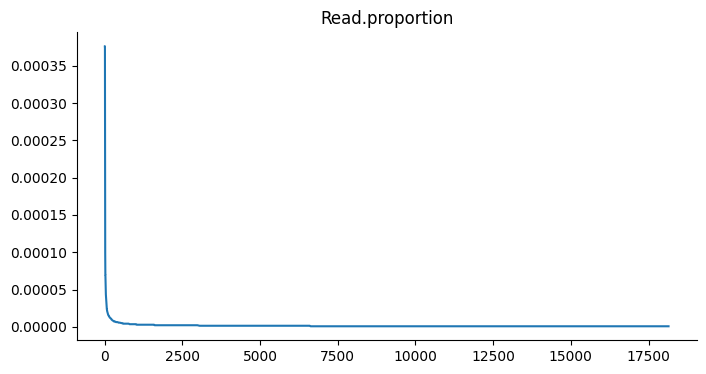

In [13]:
# @title Read.proportion

from matplotlib import pyplot as plt
full_vj['Read.proportion'].plot(kind='line', figsize=(8, 4), title='Read.proportion')
plt.gca().spines[['top', 'right']].set_visible(False)

In [14]:
full_vj['antigen.species'].value_counts()

,count
antigen.species,
CMV,707
EBV,214
SARS-CoV-2,139
InfluenzaA,133
HomoSapiens,108
HIV-1,78
HCV,39
DENV,33
TriticumAestivum,18
